In [1]:
# Import Library
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sklearn
import shutil
import random
import string
import cv2
import tempfile
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import shap
import datetime

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

# Defining the directory and image parameters
dataset_directory = '/kaggle/input/dataset-ta/Dataset_TA'
batch_size = 32
img_height = 224
img_width = 224

# Fungsi untuk mengecek gambar error
def check_corrupt_images(directory):
    corrupt_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)  # Cek apakah gambar bisa dibuka
                img.verify()  # Memverifikasi gambar
            except:
                corrupt_files.append(file_path)
                
    print(f"Total gambar corrupt: {len(corrupt_files)}")
    if corrupt_files:
        print("Daftar gambar corrupt:")
        for file in corrupt_files:
            print(file)

check_corrupt_images(dataset_directory)

# Load the full dataset
full_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred',  # Automatically labels from folder structure
    shuffle=True # Shuffle to randomize data
)

# Convert the dataset to Numpy arrays
# Iterate over the dataset to extract images and labels into arrays
image_list = []
label_list = []
for images, labels in full_dataset:
    image_list.append(images.numpy())
    label_list.append(labels.numpy())

# Convert lists to numpy arrays
X = np.concatenate(image_list)  # Concatenate all image batches into one array
y = np.concatenate(label_list)  # Concatenate all label batches into one array

# Split the data into train and temp (test+validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

# Now, split the temp dataset into validation and testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123, stratify=y_temp)

# Print the sizes of each dataset
print("Training samples:", len(X_train))
print("Validation samples:", len(X_val))
print("Testing samples:", len(X_test))

Total gambar corrupt: 0
Found 2344 files belonging to 11 classes.
Training samples: 1640
Validation samples: 352
Testing samples: 352


In [3]:
# Optionally, you can create TensorFlow Datasets from these splits
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Further processing (like batching, shuffling) can be done here:
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=1000)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [4]:
# Ambil nama kelas dari dataset
class_names = full_dataset.class_names
print("Class names:", class_names)

Class names: ['Athlete Foot', 'BCC', 'Cellulitis', 'Chickenpox', 'Impetigo', 'Keratosis', 'Melanoma', 'NV', 'Nail Fungus', 'Ringworm', 'Shingles']


In [5]:
# Fungsi untuk menyimpan dataset ke direktori
def save_dataset_to_directory(dataset, dataset_dir, class_names):
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)

    image_counter = 0  # Counter global untuk memberikan nama file unik
    for images, labels in dataset:
        for i in range(len(images)):
            # Ambil nama kelas dari label
            class_name = class_names[labels[i].numpy()]
            class_dir = os.path.join(dataset_dir, class_name)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)

            # Simpan gambar ke direktori
            image = tf.keras.preprocessing.image.array_to_img(images[i].numpy())
            file_name = f"{class_name}_{image_counter}.jpg"
            file_path = os.path.join(class_dir, file_name)
            image.save(file_path)
            image_counter += 1

# Direktori untuk menyimpan dataset
train_dir = '/kaggle/working/train_dir'
validation_dir = '/kaggle/working/validation_dir'
testing_dir = '/kaggle/working/testing_dir'

# Simpan dataset ke direktori
if train_dataset:
    save_dataset_to_directory(train_dataset, train_dir, class_names)
else:
    print("Training dataset kosong.")

if val_dataset:
    save_dataset_to_directory(val_dataset, validation_dir, class_names)
else:
    print("Validation dataset kosong.")

if test_dataset:
    save_dataset_to_directory(test_dataset, testing_dir, class_names)
else:
    print("Testing dataset kosong.")

print("Dataset telah disimpan ke direktori masing-masing!")

Dataset telah disimpan ke direktori masing-masing!


In [6]:
import pandas as pd

# Fungsi untuk menghitung distribusi kelas
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(validation_dir)
test_counts = count_images_per_class(testing_dir)

# Membuat DataFrame
df_distribution = pd.DataFrame({
    "Kelas": list(train_counts.keys()),
    "Training": list(train_counts.values()),
    "Validation": list(val_counts.values()),
    "Testing": list(test_counts.values())
})

# Menampilkan Tabel Distribusi
print(df_distribution)

           Kelas  Training  Validation  Testing
0       Shingles       114          24       25
1            BCC       218          47       47
2     Cellulitis       118          25       25
3       Impetigo        70          15       15
4     Chickenpox       119          26       25
5       Ringworm        79          17       17
6    Nail Fungus       113          24       25
7      Keratosis       243          52       53
8       Melanoma       311          67       66
9   Athlete Foot        87          19       18
10            NV       168          36       36


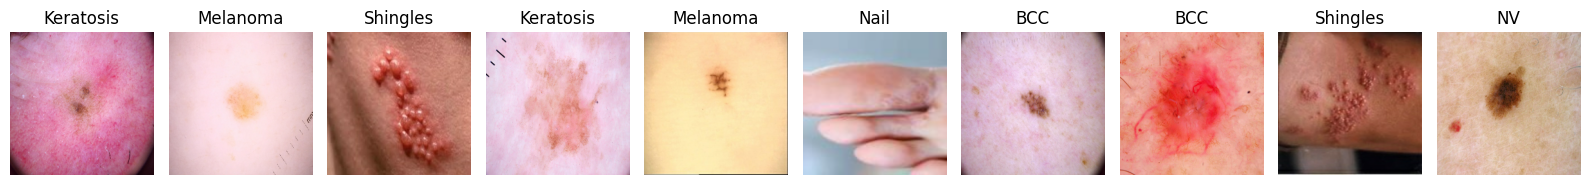

In [7]:
# Plotting a sample of 10 images from the training set
def plot_categories(train_dataset, class_names):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for images, labels in train_dataset.take(1):
    for k in range(10):
      img = images[k].numpy()
      img = array_to_img(img)
      ax = axes[k]
      label = class_names[int(labels[k])]
      simplified_label = label.split()[0]
      ax.imshow(img, cmap="Greys_r")
      ax.set_title(simplified_label)
      ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(train_dataset, class_names)

In [8]:
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Path ke direktori training dataset
train_dir = "/kaggle/input/datasetta-terbagi/train_dir"

# Dapatkan daftar kelas (subfolder dalam train_dir)
class_names = sorted(os.listdir(train_dir))

# Hitung jumlah sampel per kelas
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names}

# Konversi ke format yang bisa digunakan di compute_class_weight
y_train = np.concatenate([[i] * count for i, (class_name, count) in enumerate(class_counts.items())])

# Hitung class weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Simpan class weight dalam dictionary
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)


Class Weights: {0: 1.7136886102403344, 1: 0.6839032527105922, 2: 1.263482280431433, 3: 1.252864782276547, 4: 2.1298701298701297, 5: 0.613542835765058, 6: 0.47939199064600996, 7: 0.8874458874458875, 8: 1.3193885760257442, 9: 1.8872266973532796, 10: 1.3078149920255184}


In [9]:
# Direktori untuk dataset
train_dataset_dir = '/kaggle/working/train_dir'
validation_dataset_dir = '/kaggle/working/validation_dir'
testing_dataset_dir = '/kaggle/working/testing_dir'

# Augmentation configuration for the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for the validation and testing datasets
validation_datagen = ImageDataGenerator(rescale=1./255)
testing_datagen = ImageDataGenerator(rescale=1./255)

# Creating the training dataset generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

# Creating the validation dataset generator
validation_generator = validation_datagen.flow_from_directory(
    directory=validation_dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse'
)

# Creating the testing dataset generator
test_generator = testing_datagen.flow_from_directory(
    directory=testing_dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False  # Disable shuffling for consistent evaluation
)

# Printing class names (same for all generators)
class_names = list(train_generator.class_indices.keys())
print(f"Class: {class_names}")

Found 1640 images belonging to 11 classes.
Found 352 images belonging to 11 classes.
Found 352 images belonging to 11 classes.
Class: ['Athlete Foot', 'BCC', 'Cellulitis', 'Chickenpox', 'Impetigo', 'Keratosis', 'Melanoma', 'NV', 'Nail Fungus', 'Ringworm', 'Shingles']


In [10]:
# Define the base model
weights_path = '/kaggle/input/densenet-keras/DenseNet-BC-121-32-no-top.h5'
base_model = DenseNet121(input_shape=(img_height, img_width, 3), include_top=False, weights=None)
base_model.load_weights(weights_path)
base_model.trainable = True
for layer in base_model.layers[-35:]:  # Misalnya, unfreeze 35 layer terakhir
    layer.trainable = True
    
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(11, activation='softmax')(x)  # 11 classes

# Create the final model using Functional API
model = Model(inputs=base_model.input, outputs=output)

optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define custom callback
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.935 and logs.get('val_accuracy') > 0.935:
            print(f"\nReached 93.5% accuracy and validation accuracy. Stopping training.")
            self.model.stop_training = True

# Instantiate the custom callback
callback = MyCallback()

checkpoint_callback = ModelCheckpoint(
    'best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[callback, checkpoint_callback]
)

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Epoch 1/100


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2424 - loss: 2.7210
Epoch 1: val_accuracy improved from -inf to 0.53693, saving model to best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 291s 3s/step - accuracy: 0.2445 - loss: 2.7092 - val_accuracy: 0.5369 - val_loss: 1.5416
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.5831 - loss: 1.2099
Epoch 2: val_accuracy improved from 0.53693 to 0.73011, saving model to best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step - accuracy: 0.5838 - loss: 1.2072 - val_accuracy: 0.7301 - val_loss: 0.9842
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.7286 - loss: 0.7131
Epoch 3: val_accuracy improved from 0.73011 to 0.80114, saving model to best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 368ms/step - accuracy: 0.7286 - loss: 0.7130 - val_accuracy: 0.8011 - val_loss: 0.7521
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7559 - loss: 0.6142
Epoch 4: val_accuracy did not improve from 0.80114


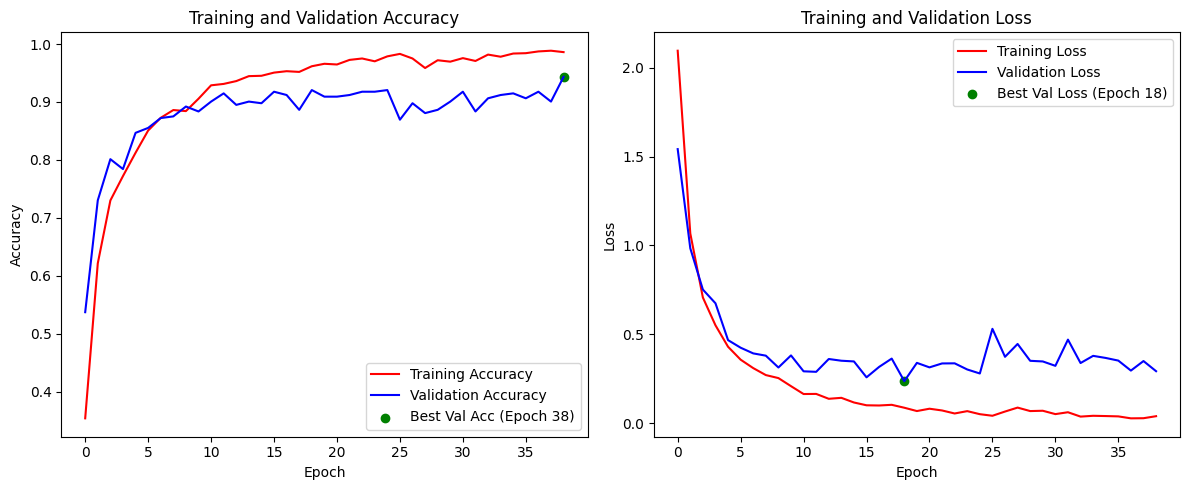

In [11]:
# Plotting the chart for accuracy and loss on both training and validation for analysis process
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Menentukan best epoch berdasarkan validasi akurasi & loss
best_epoch_acc = np.argmax(val_acc)  # Epoch dengan validasi akurasi tertinggi
best_epoch_loss = np.argmin(val_loss)  # Epoch dengan validasi loss terendah

plt.figure(figsize=(12, 5))

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.scatter(best_epoch_acc, val_acc[best_epoch_acc], color='green', marker='o', label=f'Best Val Acc (Epoch {best_epoch_acc})')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(best_epoch_loss, val_loss[best_epoch_loss], color='green', marker='o', label=f'Best Val Loss (Epoch {best_epoch_loss})')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step


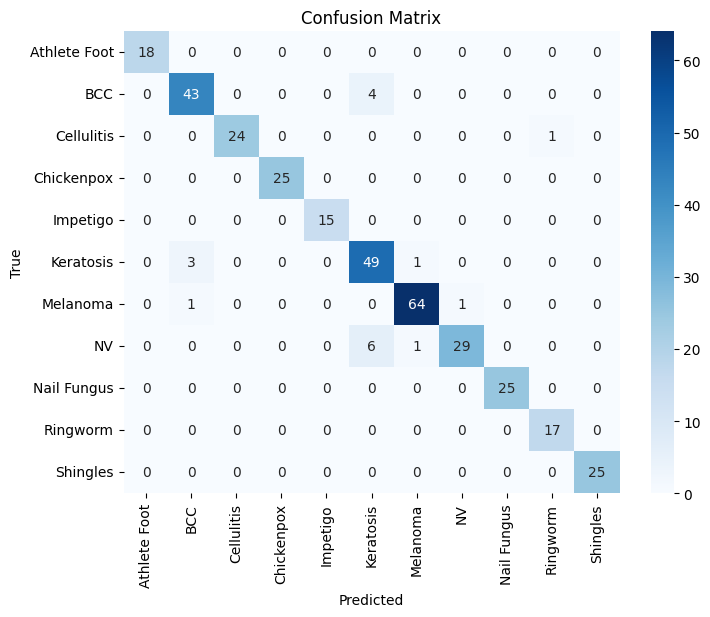

              precision    recall  f1-score   support

Athlete Foot       1.00      1.00      1.00        18
         BCC       0.91      0.91      0.91        47
  Cellulitis       1.00      0.96      0.98        25
  Chickenpox       1.00      1.00      1.00        25
    Impetigo       1.00      1.00      1.00        15
   Keratosis       0.83      0.92      0.88        53
    Melanoma       0.97      0.97      0.97        66
          NV       0.97      0.81      0.88        36
 Nail Fungus       1.00      1.00      1.00        25
    Ringworm       0.94      1.00      0.97        17
    Shingles       1.00      1.00      1.00        25

    accuracy                           0.95       352
   macro avg       0.97      0.96      0.96       352
weighted avg       0.95      0.95      0.95       352



In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Prediksi pada test set
test_predictions = model.predict(test_generator)
# Ambil argmax untuk label prediksi karena model menggunakan softmax pada output
test_predictions = np.argmax(test_predictions, axis=1)

# Ambil label asli dari test set (y_test)
test_labels = test_generator.classes

# Hitung confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Mendapatkan urutan class names sesuai dengan test_generator
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
print(classification_report(test_labels, test_predictions, target_names=class_names))

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 21,742,947 (82.94 MB)

 Trainable params: 7,219,595 (27.54 MB)

 Non-trainable params: 84,160 (328.75 KB)

 Optimizer params: 14,439,192 (55.08 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


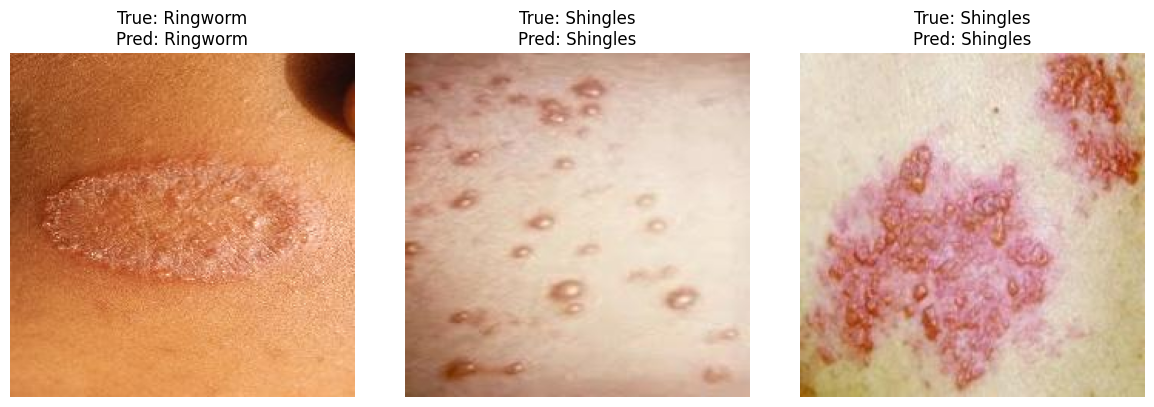

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# PIL untuk menampilkan gambar
from PIL import Image

# Fungsi untuk memilih tiga gambar acak dari test dataset
def get_random_images(generator, num_images=3):
    batch = random.randint(0, len(generator) - 1)  # Pilih batch secara acak
    images, labels = generator[batch]  # Ambil satu batch gambar dan label
    indices = random.sample(range(len(images)), num_images)  # Pilih indeks acak
    
    selected_images = [images[i] for i in indices]
    selected_labels = [labels[i] for i in indices]
    
    return selected_images, selected_labels

# Ambil tiga gambar acak dari test dataset
test_images, test_labels = get_random_images(test_generator, num_images=3)

# Prediksi model untuk semua gambar
test_images_expanded = np.array([np.expand_dims(img, axis=0) for img in test_images])  # Tambahkan batch dimensi
preds = [model.predict(img) for img in test_images_expanded]
pred_labels = [np.argmax(pred) for pred in preds]

# Tampilkan gambar beserta prediksi model
plt.figure(figsize=(12, 4))

for i in range(3):  
    plt.subplot(1, 3, i + 1)  
    plt.imshow(test_images[i])
    true_label = class_names[int(test_labels[i])]
    pred_label = class_names[pred_labels[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


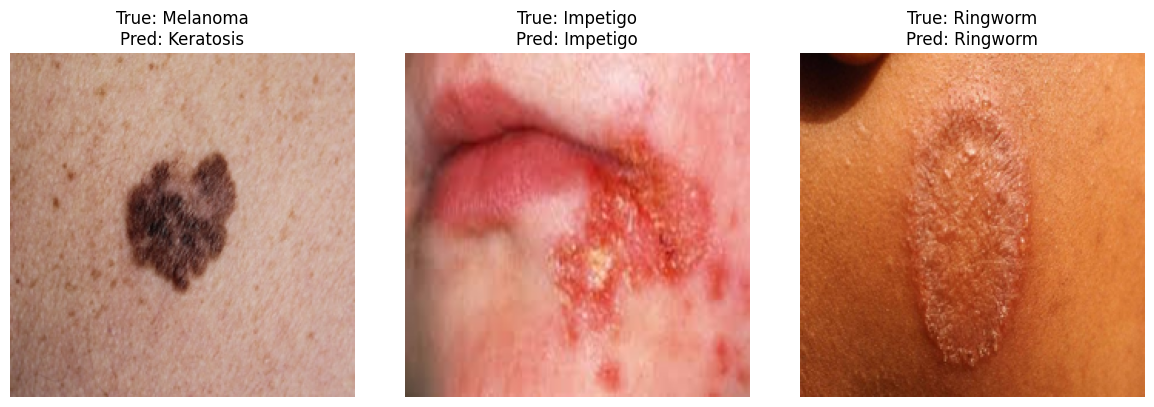

In [15]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from PIL import Image

# Direktori gambar percobaan
test_images_dir = "/kaggle/input/percobaan-gambar/percobaan_gambar"

# Ambil daftar gambar dalam folder
image_files = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith((".jpg", ".jpeg", ".png"))]

# Pilih 3 gambar secara acak
selected_files = random.sample(image_files, 3)

# Fungsi untuk memproses gambar
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)  # Buka gambar
    img = img.resize(target_size)  # Resize ke ukuran model
    img = np.array(img) / 255.0  # Normalisasi (0-1)
    
    # Jika gambar grayscale, ubah ke RGB
    if len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)
    
    return img

# Ambil nama kelas dari folder dataset utama
dataset_dir = "/kaggle/input/dataset-ta/Dataset_TA"
class_names = sorted(os.listdir(dataset_dir))  # Pastikan urutannya sesuai dengan model

# Proses gambar dan ambil label asli dari nama file
test_images = []
true_labels = []
for img_path in selected_files:
    test_images.append(preprocess_image(img_path))
    
    # Ambil nama file tanpa ekstensi dan cocokkan dengan class_names
    file_name = os.path.basename(img_path).split(".")[0]
    true_labels.append(file_name)

# Prediksi model
test_images_expanded = np.array([np.expand_dims(img, axis=0) for img in test_images])  # Tambahkan batch dimensi
preds = [model.predict(img) for img in test_images_expanded]
pred_labels = [np.argmax(pred) for pred in preds]

# Tampilkan gambar dengan prediksi & label asli
plt.figure(figsize=(12, 4))

for i in range(3):  
    plt.subplot(1, 3, i + 1)  
    plt.imshow(test_images[i])
    pred_label = class_names[pred_labels[i]]  # Ambil label prediksi dari class_names
    true_label = true_labels[i]  # Ambil label asli dari nama file
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


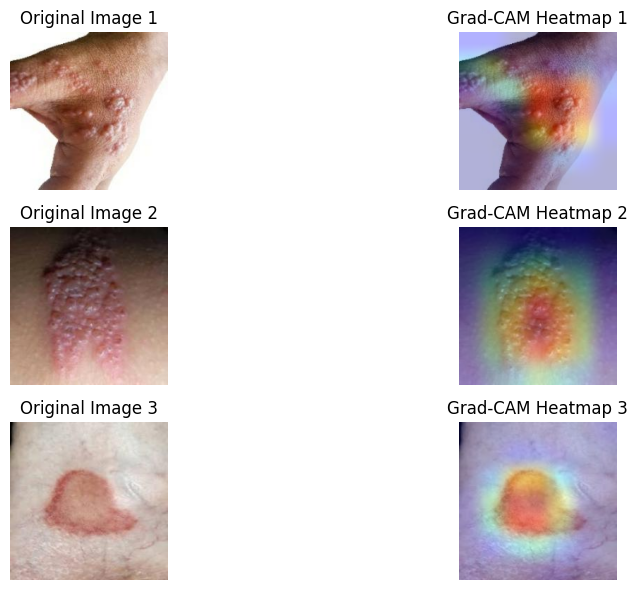

In [16]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from matplotlib import cm
import random

# Pastikan model sudah digunakan sebelumnya agar ada input yang terbentuk
dummy_input = np.zeros((1, img_height, img_width, 3))
_ = model.predict(dummy_input)

last_conv_layer_name = "conv5_block16_concat"  # Pastikan ini sesuai dengan modelmu

# Fungsi untuk mengambil tiga gambar acak dari test dataset
def get_random_images(generator, num_images=3):
    batch = random.randint(0, len(generator) - 1)  
    images, labels = generator[batch]  
    indices = random.sample(range(len(images)), num_images)  

    selected_images = [images[i] for i in indices]
    selected_labels = [labels[i] for i in indices]

    return selected_images, selected_labels

# Fungsi untuk membuat heatmap Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  # Gunakan argmax untuk memilih kelas dengan skor tertinggi
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalisasi heatmap
    return heatmap.numpy()

# Fungsi untuk overlay heatmap dengan gambar asli
def superimpose_heatmap(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)  # Konversi heatmap ke skala 0-255
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]  # Ambil warna RGB dari colormap Jet
    jet_heatmap = jet_colors[heatmap]  

    # Konversi ke gambar
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Overlay dengan gambar asli
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

# Ambil tiga gambar dari dataset
test_images, test_labels = get_random_images(test_generator, num_images=3)

# Tampilkan Grad-CAM untuk ketiga gambar
plt.figure(figsize=(12, 6))

for i in range(3):
    test_image = test_images[i]
    test_image_expanded = np.expand_dims(test_image, axis=0)  

    heatmap = make_gradcam_heatmap(test_image_expanded, model, last_conv_layer_name)

    img_cv = np.uint8(test_image * 255)  # Konversi ke format gambar asli
    superimposed_img = superimpose_heatmap(img_cv, heatmap)

    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(test_image)
    plt.title(f"Original Image {i+1}")
    plt.axis("off")

    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Heatmap {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


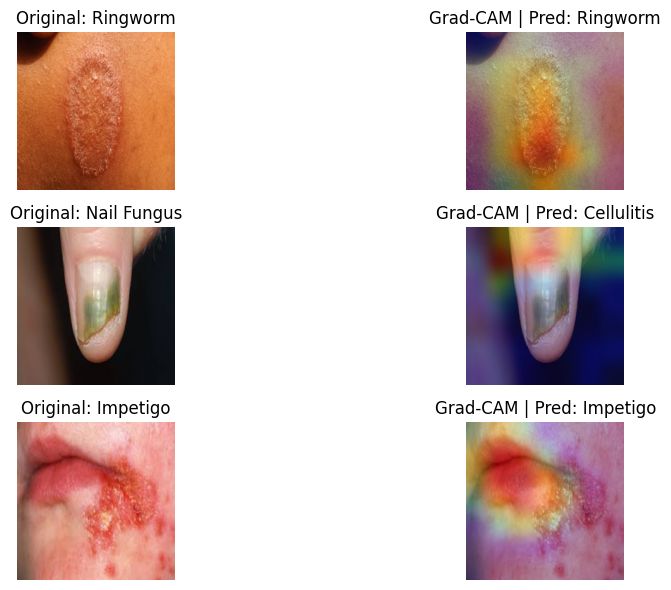

In [17]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from matplotlib import cm
from PIL import Image
import random

# Path ke folder gambar percobaan
test_images_dir = "/kaggle/input/percobaan-gambar/percobaan_gambar"

# Ambil daftar gambar dalam folder
image_files = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith((".jpg", ".jpeg", ".png"))]

# Pilih 3 gambar secara acak
selected_files = random.sample(image_files, 3)

# Fungsi untuk memproses gambar
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)  # Buka gambar
    img = img.resize(target_size)  # Resize ke ukuran model
    img = np.array(img) / 255.0  # Normalisasi (0-1)
    
    # Jika gambar grayscale, ubah ke RGB
    if len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)
    
    return img

# Ambil nama kelas dari folder dataset utama
dataset_dir = "/kaggle/input/dataset-ta/Dataset_TA"
class_names = sorted(os.listdir(dataset_dir))  # Pastikan urutannya sesuai dengan model

# Load dan proses gambar
test_images = []
true_labels = []
for img_path in selected_files:
    test_images.append(preprocess_image(img_path))
    
    # Ambil nama file tanpa ekstensi sebagai label asli
    file_name = os.path.basename(img_path).split(".")[0]
    true_labels.append(file_name)

# Pastikan model sudah digunakan sebelumnya agar ada input yang terbentuk
dummy_input = np.zeros((1, 224, 224, 3))
_ = model.predict(dummy_input)

last_conv_layer_name = "conv5_block16_concat"  # Pastikan ini sesuai dengan modelmu

# Fungsi untuk membuat heatmap Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  # Gunakan argmax untuk memilih kelas dengan skor tertinggi
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalisasi heatmap
    return heatmap.numpy(), pred_index.numpy()

# Fungsi untuk overlay heatmap dengan gambar asli
def superimpose_heatmap(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)  # Konversi heatmap ke skala 0-255
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]  # Ambil warna RGB dari colormap Jet
    jet_heatmap = jet_colors[heatmap]  

    # Konversi ke gambar
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Overlay dengan gambar asli
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

# Prediksi model dan buat Grad-CAM untuk setiap gambar
plt.figure(figsize=(12, 6))

for i in range(3):
    test_image = test_images[i]
    test_image_expanded = np.expand_dims(test_image, axis=0)  

    heatmap, pred_idx = make_gradcam_heatmap(test_image_expanded, model, last_conv_layer_name)

    img_cv = np.uint8(test_image * 255)  # Konversi ke format gambar asli
    superimposed_img = superimpose_heatmap(img_cv, heatmap)

    # Ambil label prediksi dari class_names
    pred_label = class_names[pred_idx]  
    true_label = true_labels[i]  # Ambil label asli dari nama file

    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(test_image)
    plt.title(f"Original: {true_label}")
    plt.axis("off")

    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM | Pred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()

**COBA BEST MODEL**

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step


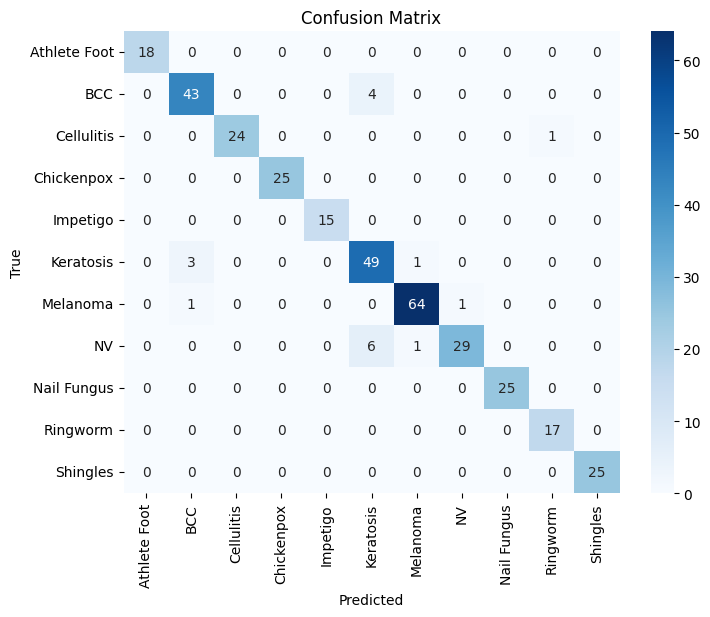

              precision    recall  f1-score   support

Athlete Foot       1.00      1.00      1.00        18
         BCC       0.91      0.91      0.91        47
  Cellulitis       1.00      0.96      0.98        25
  Chickenpox       1.00      1.00      1.00        25
    Impetigo       1.00      1.00      1.00        15
   Keratosis       0.83      0.92      0.88        53
    Melanoma       0.97      0.97      0.97        66
          NV       0.97      0.81      0.88        36
 Nail Fungus       1.00      1.00      1.00        25
    Ringworm       0.94      1.00      0.97        17
    Shingles       1.00      1.00      1.00        25

    accuracy                           0.95       352
   macro avg       0.97      0.96      0.96       352
weighted avg       0.95      0.95      0.95       352



In [18]:
from tensorflow.keras.models import load_model

# Load model terbaik yang sudah disimpan
best_model = load_model('best_model.keras')

# Prediksi pada test set dengan model terbaik
test_predictions = best_model.predict(test_generator)

# Ambil argmax untuk label prediksi karena model menggunakan softmax pada output
test_predictions = np.argmax(test_predictions, axis=1)

# Ambil label asli dari test set (y_test)
test_labels = test_generator.classes

# Hitung confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Mendapatkan urutan class names sesuai dengan test_generator
class_names = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
print(classification_report(test_labels, test_predictions, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


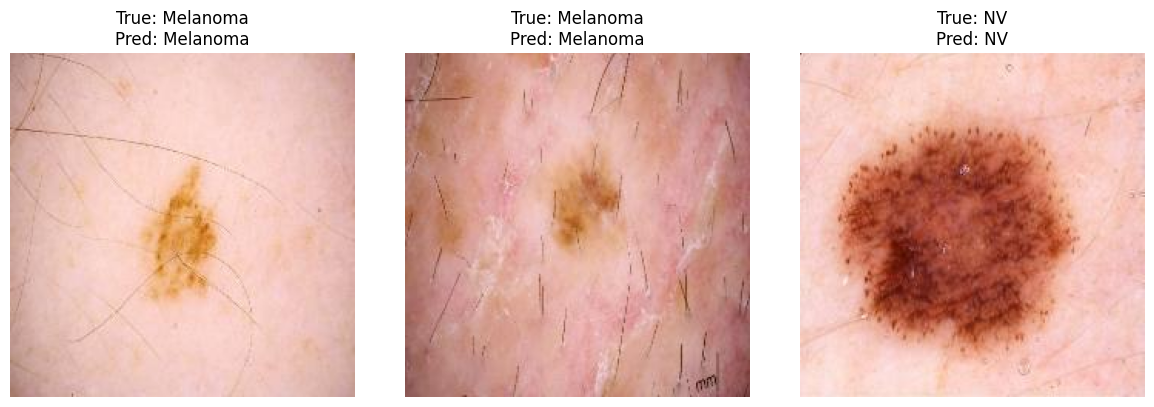

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow.keras.models import load_model

# Fungsi untuk memilih tiga gambar acak dari test dataset
def get_random_images(generator, num_images=3):
    batch = random.randint(0, len(generator) - 1)  # Pilih batch secara acak
    images, labels = generator[batch]  # Ambil satu batch gambar dan label
    indices = random.sample(range(len(images)), num_images)  # Pilih indeks acak
    
    selected_images = [images[i] for i in indices]
    selected_labels = [labels[i] for i in indices]
    
    return selected_images, selected_labels

# Ambil tiga gambar acak dari test dataset
test_images, test_labels = get_random_images(test_generator, num_images=3)

# Prediksi model untuk semua gambar dengan model terbaik
test_images_expanded = np.array([np.expand_dims(img, axis=0) for img in test_images])  # Tambahkan batch dimensi
preds = [best_model.predict(img) for img in test_images_expanded]
pred_labels = [np.argmax(pred) for pred in preds]

# Tampilkan gambar beserta prediksi model
plt.figure(figsize=(12, 4))

for i in range(3):  
    plt.subplot(1, 3, i + 1)  
    plt.imshow(test_images[i])
    true_label = class_names[int(test_labels[i])]
    pred_label = class_names[pred_labels[i]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


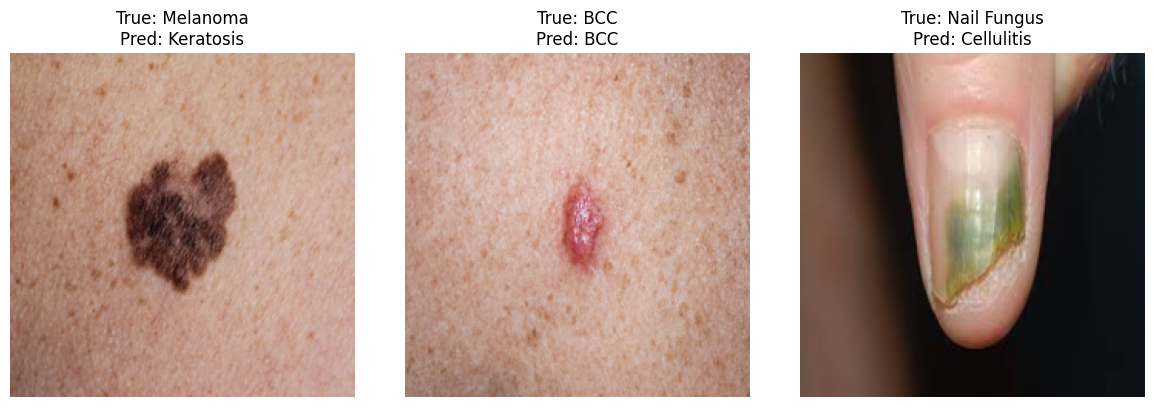

In [20]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from PIL import Image

# Direktori gambar percobaan
test_images_dir = "/kaggle/input/percobaan-gambar/percobaan_gambar"

# Ambil daftar gambar dalam folder
image_files = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith((".jpg", ".jpeg", ".png"))]

# Pilih 3 gambar secara acak
selected_files = random.sample(image_files, 3)

# Fungsi untuk memproses gambar
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)  # Buka gambar
    img = img.resize(target_size)  # Resize ke ukuran model
    img = np.array(img) / 255.0  # Normalisasi (0-1)
    
    # Jika gambar grayscale, ubah ke RGB
    if len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)
    
    return img

# Ambil nama kelas dari folder dataset utama
dataset_dir = "/kaggle/input/dataset-ta/Dataset_TA"
class_names = sorted(os.listdir(dataset_dir))  # Pastikan urutannya sesuai dengan model

# Proses gambar dan ambil label asli dari nama file
test_images = []
true_labels = []
for img_path in selected_files:
    test_images.append(preprocess_image(img_path))
    
    # Ambil nama file tanpa ekstensi dan cocokkan dengan class_names
    file_name = os.path.basename(img_path).split(".")[0]
    true_labels.append(file_name)

# Prediksi model
test_images_expanded = np.array([np.expand_dims(img, axis=0) for img in test_images])  # Tambahkan batch dimensi
preds = [best_model.predict(img) for img in test_images_expanded]
pred_labels = [np.argmax(pred) for pred in preds]

# Tampilkan gambar dengan prediksi & label asli
plt.figure(figsize=(12, 4))

for i in range(3):  
    plt.subplot(1, 3, i + 1)  
    plt.imshow(test_images[i])
    pred_label = class_names[pred_labels[i]]  # Ambil label prediksi dari class_names
    true_label = true_labels[i]  # Ambil label asli dari nama file
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


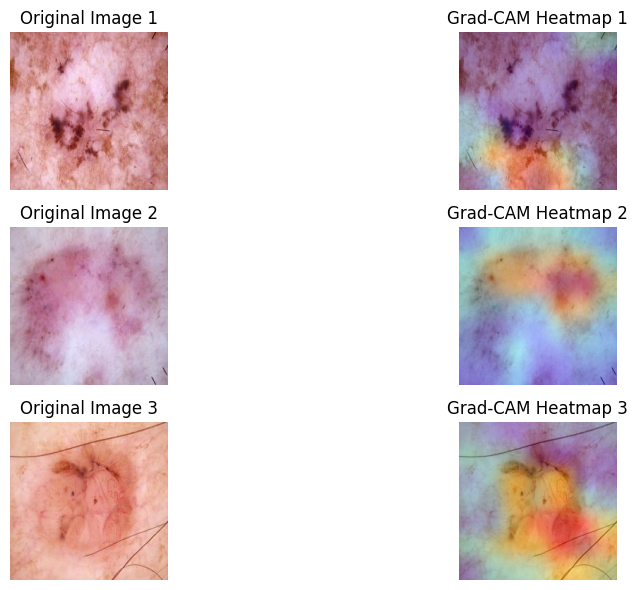

In [21]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from matplotlib import cm
import random

# Pastikan model sudah digunakan sebelumnya agar ada input yang terbentuk
dummy_input = np.zeros((1, img_height, img_width, 3))
_ = best_model.predict(dummy_input)

last_conv_layer_name = "conv5_block16_concat"  # Pastikan ini sesuai dengan modelmu

# Fungsi untuk mengambil tiga gambar acak dari test dataset
def get_random_images(generator, num_images=3):
    batch = random.randint(0, len(generator) - 1)  
    images, labels = generator[batch]  
    indices = random.sample(range(len(images)), num_images)  

    selected_images = [images[i] for i in indices]
    selected_labels = [labels[i] for i in indices]

    return selected_images, selected_labels

# Fungsi untuk membuat heatmap Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  # Gunakan argmax untuk memilih kelas dengan skor tertinggi
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalisasi heatmap
    return heatmap.numpy()

# Fungsi untuk overlay heatmap dengan gambar asli
def superimpose_heatmap(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)  # Konversi heatmap ke skala 0-255
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]  # Ambil warna RGB dari colormap Jet
    jet_heatmap = jet_colors[heatmap]  

    # Konversi ke gambar
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Overlay dengan gambar asli
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

# Ambil tiga gambar dari dataset
test_images, test_labels = get_random_images(test_generator, num_images=3)

# Tampilkan Grad-CAM untuk ketiga gambar
plt.figure(figsize=(12, 6))

for i in range(3):
    test_image = test_images[i]
    test_image_expanded = np.expand_dims(test_image, axis=0)  

    heatmap = make_gradcam_heatmap(test_image_expanded, model, last_conv_layer_name)

    img_cv = np.uint8(test_image * 255)  # Konversi ke format gambar asli
    superimposed_img = superimpose_heatmap(img_cv, heatmap)

    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(test_image)
    plt.title(f"Original Image {i+1}")
    plt.axis("off")

    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM Heatmap {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


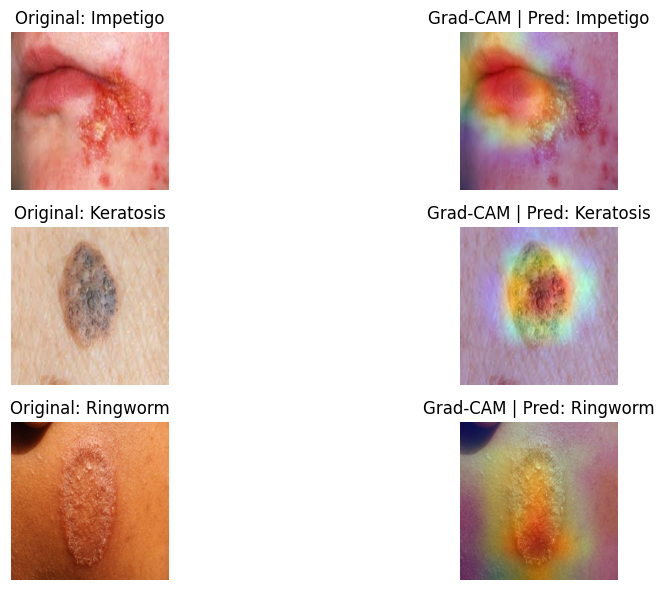

In [22]:
import os
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from matplotlib import cm
from PIL import Image
import random

# Path ke folder gambar percobaan
test_images_dir = "/kaggle/input/percobaan-gambar/percobaan_gambar"

# Ambil daftar gambar dalam folder
image_files = [os.path.join(test_images_dir, img) for img in os.listdir(test_images_dir) if img.endswith((".jpg", ".jpeg", ".png"))]

# Pilih 3 gambar secara acak
selected_files = random.sample(image_files, 3)

# Fungsi untuk memproses gambar
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)  # Buka gambar
    img = img.resize(target_size)  # Resize ke ukuran model
    img = np.array(img) / 255.0  # Normalisasi (0-1)
    
    # Jika gambar grayscale, ubah ke RGB
    if len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)
    
    return img

# Ambil nama kelas dari folder dataset utama
dataset_dir = "/kaggle/input/dataset-ta/Dataset_TA"
class_names = sorted(os.listdir(dataset_dir))  # Pastikan urutannya sesuai dengan model

# Load dan proses gambar
test_images = []
true_labels = []
for img_path in selected_files:
    test_images.append(preprocess_image(img_path))
    
    # Ambil nama file tanpa ekstensi sebagai label asli
    file_name = os.path.basename(img_path).split(".")[0]
    true_labels.append(file_name)

# Pastikan model sudah digunakan sebelumnya agar ada input yang terbentuk
dummy_input = np.zeros((1, 224, 224, 3))
_ = best_model.predict(dummy_input)

last_conv_layer_name = "conv5_block16_concat"  # Pastikan ini sesuai dengan modelmu

# Fungsi untuk membuat heatmap Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  # Gunakan argmax untuk memilih kelas dengan skor tertinggi
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalisasi heatmap
    return heatmap.numpy(), pred_index.numpy()

# Fungsi untuk overlay heatmap dengan gambar asli
def superimpose_heatmap(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)  # Konversi heatmap ke skala 0-255
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]  # Ambil warna RGB dari colormap Jet
    jet_heatmap = jet_colors[heatmap]  

    # Konversi ke gambar
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Overlay dengan gambar asli
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

# Prediksi model dan buat Grad-CAM untuk setiap gambar
plt.figure(figsize=(12, 6))

for i in range(3):
    test_image = test_images[i]
    test_image_expanded = np.expand_dims(test_image, axis=0)  

    heatmap, pred_idx = make_gradcam_heatmap(test_image_expanded, model, last_conv_layer_name)

    img_cv = np.uint8(test_image * 255)  # Konversi ke format gambar asli
    superimposed_img = superimpose_heatmap(img_cv, heatmap)

    # Ambil label prediksi dari class_names
    pred_label = class_names[pred_idx]  
    true_label = true_labels[i]  # Ambil label asli dari nama file

    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(test_image)
    plt.title(f"Original: {true_label}")
    plt.axis("off")

    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM | Pred: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()